# GENOVA: explore the Hi-Cs
> 从此处摘抄、翻译、理解和应用
>
> https://github.com/robinweide/GENOVA
>
> 原作者如下

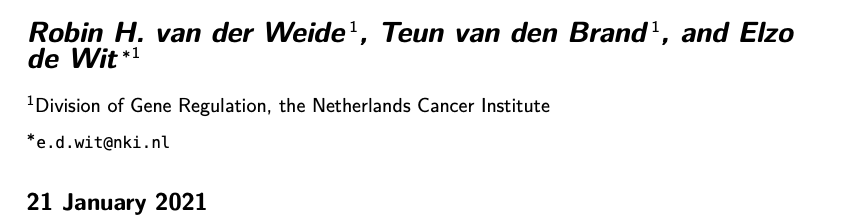

## Abstract
> The increase in interest for Hi-C methods in the chromatin community has led to a need for more user-friendly and powerful analysis methods. The few currently available software packages for Hi-C do not allow a researcher to quickly summarize and visualize their data. An easy to use software package, which can generate a comprehensive set of publication-quality plots, would allow researchers to swiftly go from raw Hi-C data to interpretable results. 
>
> Here, we present **GEN**ome **O**rganisation **V**isual **A**nalytics (GENOVA): 
> - a software suite to perform in-depth analyses on various levels of genome organisation, using Hi-C data. GENOVA facilitates the comparison between multiple datasets and supports the majority of mapping-pipelines.

染色质界对Hi-C方法兴趣的增加导致了对更多用户友好和强大分析方法的需求。目前为数不多的Hi-C软件包并不允许研究人员快速总结和可视化他们的数据。一个易于使用的软件包，能够生成一套全面的、具有出版质量的图表，将使研究人员能够迅速地从原始Hi-C数据到可解释的结果。

在这里，我们提出了**基因**组**组织**视觉**分析（GENOVA）:
- 这套软件可以利用Hi-C数据对基因组组织的各个层面进行深入分析。GENOVA促进了多个数据集之间的比较，并支持大多数的绘图管道。


## Input data

In [69]:
# install.packages("remotes")

# remotes::update_packages()
# 1: All

# remotes::install_github("robinweide/GENOVA")

# if use juicer and .hic file
# remotes::install_cran("strawr")

# if use get_test_data
# remotes::install_cran("pkgfilecache")


# for plot figure theme
# remotes::install_cran('ggthemes', dependencies = TRUE)
# remotes::install_cran('ggprism', dependencies = TRUE)
# remotes::install_cran('cowplot', dependencies = TRUE)

In [70]:
library(GENOVA)
library(tidyverse)
library(ggprism)
library(cowplot)

## Data structures of input
GENOVA expects two input files: 
- the signal
    - Signal-files have three columns (bin1, bin2, contactCount)
- and the index-file
    - index-files have four (chromosome, start, end, bin). These are the default output of the Hi-C mapping pipeline HiC-Pro, where they are called \*.matrix and \*.bed. The files are expected to be genome-wide and may be corrected with ICE-normalisation.


### Recommended resolutions 【重点】
To ensure computational strain and time is kept to a minimum, we recommend different resolutions for different functions (table1) 

More experienced users are free to deviate, while keeping in mind that these datasets are quite memory-heavy (table2) 

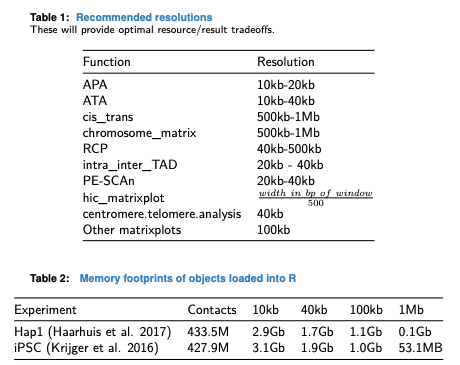

Several functions rely on centromere-information. You can add this in the form of a BED-like three-column data.frame when constructing the experiment-object ^[Please make sure that the chromosome-names match.]. If not present, the centromeres will be emperically identified by searching for the largest stretch of no coverage on a chromosome.

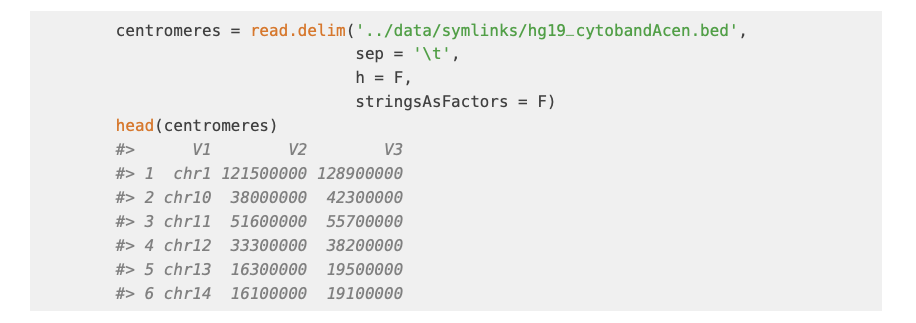

#### Get centromere.bed from UCSC GenomeBrowser
> https://groups.google.com/a/soe.ucsc.edu/g/genome/c/c9eZ_fywMbo/m/2sgUU2QaAwAJ

You can get slightly different centromere coordinates than the centromeres track via the cytoBandIdeo table. 

- Similar to before, head to the Table Browser
- Choose the *Mapping and Sequencing* group
- Select the *ChromosomeBand (Ideogram)* track
- Then select filter, and enter "*cen*" in the *gieStain* field
- This leads to output like the following:

```
chr1 121700000 123400000 p11.1 acen
chr1 123400000 125100000 q11 acen
chr2 91800000 93900000 p11.1 acen
chr2 93900000 96000000 q11.1 acen
...
```

Here each chromosome will have two entries, and will overlap so you can merge them into a single entry. Unfortunately, these coordinates will differ from those in the centromeres track, even if you were to create single, per chromosome entries out of the centromeres track items. You may find this previously answered mailing list question helpful in deciding what data set to choose: https://groups.google.com/a/soe.ucsc.edu/d/msg/genome/SaR2y4UNrWg/XsGdMI3AazgJ

IF you have any further questions, please reply to gen...@soe.ucsc.edu. 

All messages sent to that address are archived on a publicly-accessible forum. If your question includes sensitive data, you may send it instead to genom...@soe.ucsc.edu.

Christopher Lee

UCSC Genomics Institute

On Thu, Jan 26, 2017 at 8:58 AM, Jeltje van Baren

In [3]:
# # hg38 centromeres
# centromeres_hg38_raw = read_tsv('program/ucsc_hg38_MappingAndSequencing_ChromosomeBandIdeogram_genome_filter_cen.bed',
#                         col_names=c('chrom', 'start', 'stop', 'anno'))
# centromeres_hg38 <- centromeres_hg38_raw %>% select(chrom, start, stop) %>% 
#     group_by(chrom) %>% summarize(start=min(start), stop=max(stop))

# # centromeres_hg38

# centromeres <- centromeres_hg38
# head(centromeres)

### Loading data
Every Hi-C experiment will be stored in an experiment-object. 

This is done by invoking the `construct.experiment` function. 

Inside, several sanity checks will be performed, data is normalised to the total number of reads and scaled to a billion reads (the default value of the `BPscaling`-option). 

For this example, we are going to use the Hi-C maps of WT and $\Delta$WAPL Hap1 cells from Haarhuis et al. [-@Haarhuis2017]. Since the genome-wide analyses do not need very high-resolution data, we will construct both 10kb, 40kb and 1Mb resolution experiment-objects. 

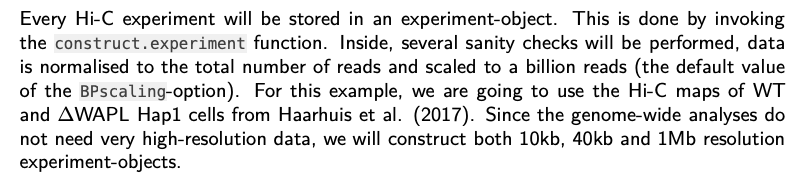

```{r CONSTRUCT, echo=T, warning=FALSE, error=F, results='hide', cache=F, cache.lazy=F}
Hap1_WT_10kb <- load_contacts(
  signal_path = '../data/symlinks/WT_10000_iced.matrix', 
  indices_path = '../data/symlinks/WT_10000_abs.bed',  
  sample_name = "WT", 
  colour = "black"
)
Hap1_WAPL_10kb <- load_contacts(
  signal_path = '../data/symlinks/WAPL_10000_iced.matrix', 
  indices_path = '../data/symlinks/WAPL_10000_abs.bed', 
  sample_name = "WAPL", 
  colour = "red"
)
Hap1_SCC4_10kb <- load_contacts(
  signal_path = '../data/symlinks/SCC4_10000_iced.matrix', 
  indices_path = '../data/symlinks/SCC4_10000_abs.bed', 
  sample_name = "SCC4", 
  colour = "green"
)
Hap1_WT_40kb <- load_contacts(
  signal_path = '../data/symlinks/WT_40000_iced.matrix', 
  indices_path = '../data/symlinks/WT_40000_abs.bed', 
  sample_name = "WT",  
  colour = "black"
)
Hap1_WAPL_40kb <- load_contacts(
  signal_path = '../data/symlinks/WAPL_40000_iced.matrix', 
  indices_path = '../data/symlinks/WAPL_40000_abs.bed', 
  sample_name = "WAPL", 
  colour = "red"
)
Hap1_WT_1MB <- load_contacts(
  signal_path = '../data/symlinks/WT_1000000_iced.matrix', 
  indices_path = '../data/symlinks/WT_1000000_abs.bed', 
  sample_name = "WT", centromeres = centromeres,
  colour = "black"
)
Hap1_WAPL_1MB <- load_contacts(
  signal_path = '../data/symlinks/WAPL_1000000_iced.matrix', 
  indices_path = '../data/symlinks/WAPL_1000000_abs.bed', 
  sample_name = "WAPL", 
  centromeres = centromeres,
  colour = "red"
)
```



The resulting `contacts`-object has several slots. `MAT` and `IDX` are the signal- and index-data.tables. We also have slots for the included chromosomes (`CHRS`) and the given centromers (`CENTROMERES`). 
```{r peekEXP1, collapse=F, results='markup', echo = F}
str(Hap1_WT_10kb, width = 60,   vec.len=0, strict.width = 'wrap')
```

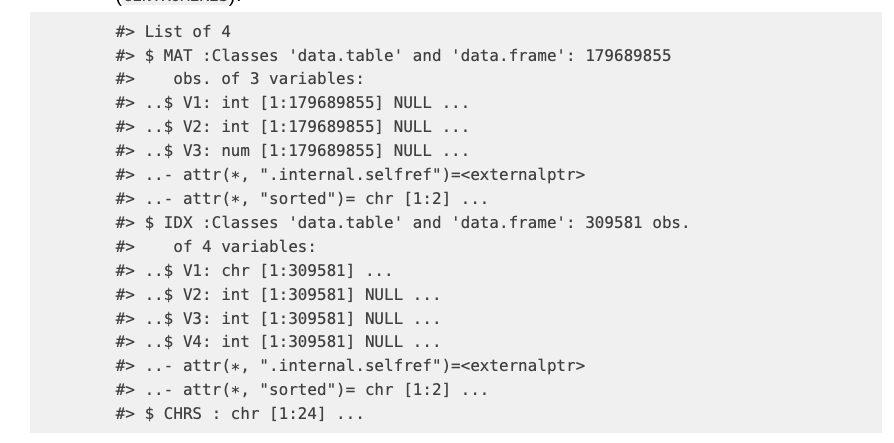

Finally, the object has a lot of specific attributes, like metadata and given parameters during loading. The amount of contacts in the *ICE* data.table is likely different from the input-data, because it is scaled to a fixed number of reads (which can be set with the `scale_bp`-option in `load_contacts()`).
```{r peekEXP2, collapse=F, results='markup', echo = F}
as.data.frame(
  attributes(Hap1_WT_10kb)
  [-1])
```


In [4]:
## load treatment 1: auxin2days

In [12]:
# 10kb
mESC_auxin_2days_rep1_10kb <- load_contacts(signal_path = '../matrix/10000/Hi-C_auxin-2days_rep1_10000_iced.matrix',
                              indices_path = '../matrix/10000/Hi-C_auxin-2days_rep1_10000_raw_abs.bed',
                              sample_name = "auxin-2days_rep1", 
                              colour = "red")
mESC_auxin_2days_rep2_10kb <- load_contacts(signal_path = '../matrix/10000/Hi-C_auxin-2days_rep2_10000_iced.matrix',
                              indices_path = '../matrix/10000/Hi-C_auxin-2days_rep2_10000_raw_abs.bed',
                              sample_name = "auxin-2days_rep2", 
                              colour = "red")
# 50kb
mESC_auxin_2days_rep1_50kb <- load_contacts(signal_path = '../matrix/50000/Hi-C_auxin-2days_rep1_50000_iced.matrix',
                              indices_path = '../matrix/50000/Hi-C_auxin-2days_rep1_50000_raw_abs.bed',
                              sample_name = "auxin-2days_rep1", 
                              colour = "red")
mESC_auxin_2days_rep2_50kb <- load_contacts(signal_path = '../matrix/50000/Hi-C_auxin-2days_rep2_50000_iced.matrix',
                              indices_path = '../matrix/50000/Hi-C_auxin-2days_rep2_50000_raw_abs.bed',
                              sample_name = "auxin-2days_rep2", 
                              colour = "red")
# 1M
mESC_auxin_2days_rep1_1M <- load_contacts(signal_path = '../matrix/1000000/Hi-C_auxin-2days_rep1_1000000_iced.matrix',
                              indices_path = '../matrix/1000000/Hi-C_auxin-2days_rep1_1000000_raw_abs.bed',
                              sample_name = "auxin-2days_rep1", 
                              colour = "red")
mESC_auxin_2days_rep2_1M <- load_contacts(signal_path = '../matrix/1000000/Hi-C_auxin-2days_rep2_1000000_iced.matrix',
                              indices_path = '../matrix/1000000/Hi-C_auxin-2days_rep2_1000000_raw_abs.bed',
                              sample_name = "auxin-2days_rep2", 
                              colour = "red")

Reading data...

Reading data...

Reading data...

Reading data...

Reading data...

Reading data...



In [13]:
## load treatment 2: auxin2days

In [14]:
# 10kb
mESC_washoff_2days_rep1_10kb <- load_contacts(signal_path = '../matrix/10000/Hi-C_washoff-2days_rep1_10000_iced.matrix',
                              indices_path = '../matrix/10000/Hi-C_washoff-2days_rep1_10000_raw_abs.bed',
                              sample_name = "washoff-2days_rep1", 
                              colour = "pink")
mESC_washoff_2days_rep2_10kb <- load_contacts(signal_path = '../matrix/10000/Hi-C_washoff-2days_rep2_10000_iced.matrix',
                              indices_path = '../matrix/10000/Hi-C_washoff-2days_rep2_10000_raw_abs.bed',
                              sample_name = "washoff-2days_rep2", 
                              colour = "pink")
# 50kb
mESC_washoff_2days_rep1_50kb <- load_contacts(signal_path = '../matrix/50000/Hi-C_washoff-2days_rep1_50000_iced.matrix',
                              indices_path = '../matrix/50000/Hi-C_washoff-2days_rep1_50000_raw_abs.bed',
                              sample_name = "washoff-2days_rep1", 
                              colour = "pink")
mESC_washoff_2days_rep2_50kb <- load_contacts(signal_path = '../matrix/50000/Hi-C_washoff-2days_rep2_50000_iced.matrix',
                              indices_path = '../matrix/50000/Hi-C_washoff-2days_rep2_50000_raw_abs.bed',
                              sample_name = "washoff-2days_rep2", 
                              colour = "pink")
# 1M
mESC_washoff_2days_rep1_1M <- load_contacts(signal_path = '../matrix/1000000/Hi-C_washoff-2days_rep1_1000000_iced.matrix',
                              indices_path = '../matrix/1000000/Hi-C_washoff-2days_rep1_1000000_raw_abs.bed',
                              sample_name = "washoff-2days_rep1", 
                              colour = "pink")
mESC_washoff_2days_rep2_1M <- load_contacts(signal_path = '../matrix/1000000/Hi-C_washoff-2days_rep2_1000000_iced.matrix',
                              indices_path = '../matrix/1000000/Hi-C_washoff-2days_rep2_1000000_raw_abs.bed',
                              sample_name = "washoff-2days_rep2", 
                              colour = "pink")

Reading data...

Reading data...

Reading data...

Reading data...

Reading data...

Reading data...



In [15]:
## load untreated

In [16]:
# 10kb
mESC_untreated_rep1_10kb <- load_contacts(signal_path = '../matrix/10000/Hi-C_untreated_rep1_10000_iced.matrix',
                              indices_path = '../matrix/10000/Hi-C_untreated_rep1_10000_raw_abs.bed',
                              sample_name = "untreated_rep1", 
                              colour = "black")
mESC_untreated_rep2_10kb <- load_contacts(signal_path = '../matrix/10000/Hi-C_untreated_rep2_10000_iced.matrix',
                              indices_path = '../matrix/10000/Hi-C_untreated_rep2_10000_raw_abs.bed',
                              sample_name = "untreated_rep2", 
                              colour = "black")
# 50kb
mESC_untreated_rep1_50kb <- load_contacts(signal_path = '../matrix/50000/Hi-C_untreated_rep1_50000_iced.matrix',
                              indices_path = '../matrix/50000/Hi-C_untreated_rep1_50000_raw_abs.bed',
                              sample_name = "untreated_rep1", 
                              colour = "black")
mESC_untreated_rep2_50kb <- load_contacts(signal_path = '../matrix/50000/Hi-C_untreated_rep2_50000_iced.matrix',
                              indices_path = '../matrix/50000/Hi-C_untreated_rep2_50000_raw_abs.bed',
                              sample_name = "untreated_rep2", 
                              colour = "black")
# 1M
mESC_untreated_rep1_1M <- load_contacts(signal_path = '../matrix/1000000/Hi-C_untreated_rep1_1000000_iced.matrix',
                              indices_path = '../matrix/1000000/Hi-C_untreated_rep1_1000000_raw_abs.bed',
                              sample_name = "untreated_rep1", 
                              colour = "black")
mESC_untreated_rep2_1M <- load_contacts(signal_path = '../matrix/1000000/Hi-C_untreated_rep2_1000000_iced.matrix',
                              indices_path = '../matrix/1000000/Hi-C_untreated_rep2_1000000_raw_abs.bed',
                              sample_name = "untreated_rep2", 
                              colour = "black")

Reading data...

Reading data...

Reading data...

Reading data...

Reading data...

Reading data...



### Quickstart
If you want to take GENOVA for a spin or compare outputs, we have included some optional test data at 40k and 150k resolution of just two smaller human chromosomes. You can find more details about the data itself in the `?get_test_data` documentation. The `get_test_data()` function downloads and caches a pre-loaded contacts object that can be used in subsequent analysis. Below we'll demonstrate how to get the test data and directly use it in plotting.

```{r, testdata, out.width='.25\\linewidth', fig.show='hold',fig.align='center',  message=FALSE , fig.asp=1,fig.cap= "Jotting down a quick plot of the test data.",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.wide = T}
test_exp <- get_test_data("40k", download = TRUE)
hic_matrixplot(
  test_exp,
  chrom = "chr21", start = 20e6, end = 30e6,
  cut.off = 500
)
```

To clear the local cache of test data, you can use the `erase_GENOVA_cache()` function. If you want to use the test data after erasing the cache, you'd need to re-download the data.


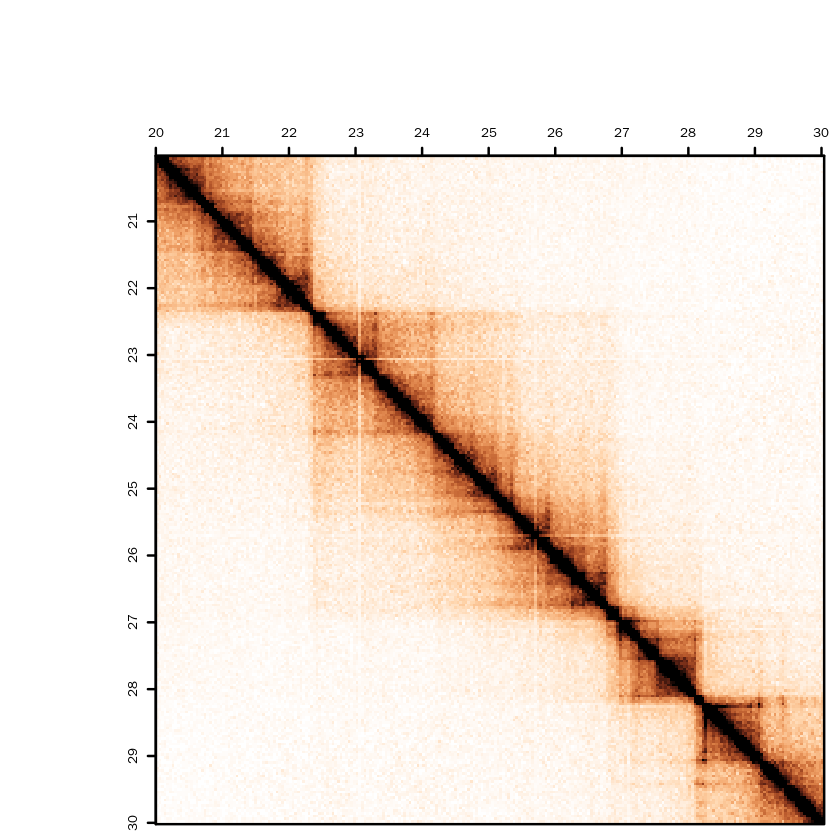

In [17]:
# test_exp <- get_test_data("40k", download = TRUE)
test_exp <- get_test_data("40k", download = FALSE)
hic_matrixplot(
  test_exp,
  chrom = "chr21", start = 20e6, end = 30e6,
  cut.off = 500
)

### Juicebox & cooler
Both `.hic` and `.cooler` files can be loaded from version 1 onwards. The same `load_contacts()` function can be used, which will automatically determine the file-type based on the extention. 

```{r J2G, eval=FALSE, highlight=FALSE}
Hap1_WT_10kb_juicer <- load_contacts(signal_path = '../data/symlinks/WT.hic', 
                                     sample_name = "WT", 
                                     resolution = 10e3, 
                                     balancing = 'KR', # this is the default
			                               colour = "black")
Hap1_WT_10kb_cooler <- load_contacts(signal_path = '../data/symlinks/WT.cooler', 
                                     sample_name = "WT", 
                                     balancing = T,
			                               colour = "black")
```


# 【重点】Genome-wide analyses
A good place to start your analyses are some functions on a genome-wide level. We can assess the quality of the library, identify translocations and generate contact probability (aka scaling or interaction decay plots).

开始分析的一个好地方是全基因组水平上的一些功能。我们可以评估文库的质量，识别易位并生成接触概率`contact probability`（又称缩放图或相互作用衰减图`aka scaling or interaction decay plots`）。


## 【重点】*Cis*-quantification
Work by the group of Amos Tanay showed that the expected amount of intra-chromosomal contacts is the range of 90 to 93 percent [@Olivares-Chauvet2016]. Assuming that any extra inter-chromosomal contacts are due to debris/noise, the user might aspire to get the *cis*-percentages as close to 90% as possible. To compute the percentage of per-sample *cis*-contacts, we simply provide `cis_trans()` with the contacts-object of interest. The output can be used to make a barplot of the percentages *cis* per sample (figure 2). 

Amos Tanay小组的工作表明，染色体内接触的预期数量在90%到93%之间[@Olivares-Chauvet2016]。假设任何额外的染色体间接触是由于碎片/噪音造成的，用户可能希望顺式百分比尽可能地接近90%。为了计算每个样本顺式接触的百分比，我们只需将感兴趣的接触对象提供给cis_trans()。输出结果可用于制作每个样本顺式百分比的柱状图（图2）。

```{r cis, cache=F,fig.cap="Fraction of cis-contacts per sample. Red dotted line denote the percentage-range from Olivares et al..", fig.small = T}
cisChrom_out <- cis_trans( list(Hap1_WT_1MB, Hap1_WAPL_1MB) )
barplot(cisChrom_out$cis, names.arg = cisChrom_out$sample, ylim = c(0, 100) )
abline(h = cisChrom_out$cis[1], col = 'red', lty = 3)
abline(h = cisChrom_out$cis[2], col = 'red', lty = 3)
```

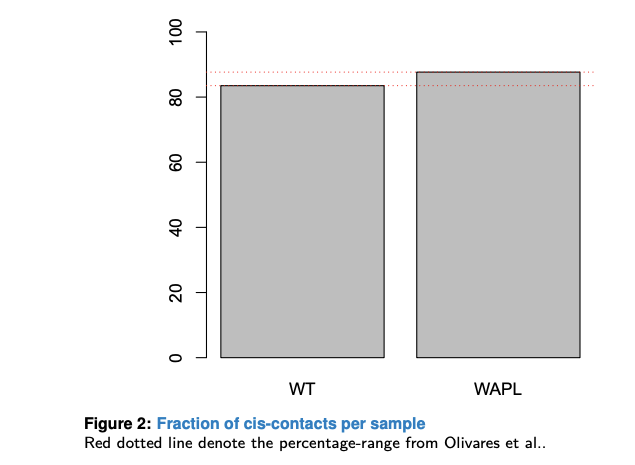

The same function can also be ran on specific regions. For this example, we will compute the intra-arm percentages. Plotting this shows us that there are interesting differences between the amounts of intra-arm contacts in *cis*, which is can be attributed to the loss of TADs [@Haarhuis2017] (figure 3). 

同样的功能也可以在特定区域运行。在这个例子中，我们将计算出臂内的百分比。绘图显示我们在顺式的臂内接触量之间存在有趣的差异，这可以归因于TADs的损失[@Haarhuis2017]（图3）。


```{r cis2, cache=F,fig.cap="Fraction of cis-contacts per sample at the p-arms.", fig.small = T}
p_arms <- data.frame('chromosome' = centromeres[,1],
                     'start' = 0,
                     'end' = centromeres[,2])
cisChrom_out <- cis_trans( list(Hap1_WT_10kb, Hap1_SCC4_10kb) , bed = p_arms)
barplot(cisChrom_out$cis, names.arg = cisChrom_out$sample, ylim = c(0, 100))
abline(h = 90, col = 'red', lty = 3)
abline(h = 93, col = 'red', lty = 3)
```

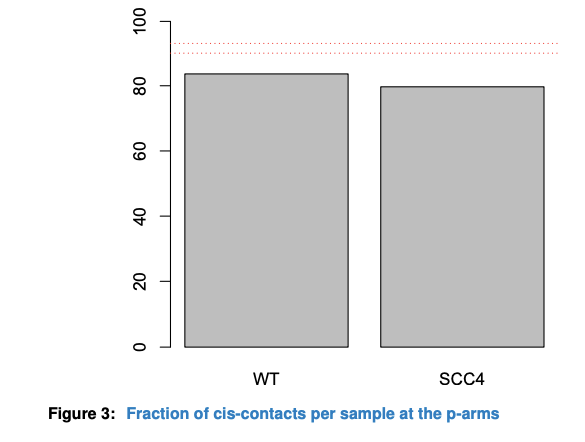

In [84]:
dir.create("../genova_plots", recursive=TRUE)

Warning message in dir.create("../genova_plots", recursive = TRUE):
“'../genova_plots'已存在”


In [87]:
samples_50kb <- list(
    mESC_auxin_2days_rep1_50kb, 
    mESC_auxin_2days_rep2_50kb,
    mESC_washoff_2days_rep1_50kb,
    mESC_washoff_2days_rep2_50kb,
    mESC_untreated_rep1_50kb,
    mESC_untreated_rep2_50kb
)


samples_1M <- list(
    mESC_auxin_2days_rep1_1M, 
    mESC_auxin_2days_rep2_1M,
    mESC_washoff_2days_rep1_1M, 
    mESC_washoff_2days_rep2_1M,
    mESC_untreated_rep1_1M,
    mESC_untreated_rep2_1M
)

In [ ]:
cisChrom_out <- cis_trans(samples_50kb)
g1 <- ggplot() + 
    geom_bar(
        data = cisChrom_out,
        mapping=aes(x=sample, y=cis, fill=sample),
        stat="identity",
    ) +
    ggtitle("Cis-quantification_50kb") + 
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by=10)) +
    geom_hline(yintercept=cisChrom_out$cis[1], lty = 3) +
    geom_hline(yintercept=cisChrom_out$cis[2], lty = 3) +
    geom_hline(yintercept=90, colour = 'red', lty = 3) +
    theme_prism(base_size = 16, axis_text_angle=45)

In [88]:
cisChrom_out <- cis_trans(samples_1M)

g2 <- ggplot() + 
    geom_bar(
        data = cisChrom_out,
        mapping=aes(x=sample, y=cis, fill=sample),
        stat="identity",
    ) +
    ggtitle("Cis-quantification_1M") + 
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by=10)) +
    geom_hline(yintercept=cisChrom_out$cis[1], lty = 3) +
    geom_hline(yintercept=cisChrom_out$cis[2], lty = 3) +
    geom_hline(yintercept=90, colour = 'red', lty = 3) +
    theme_prism(base_size = 16, axis_text_angle=45)

Saving 6.67 x 6.67 in image



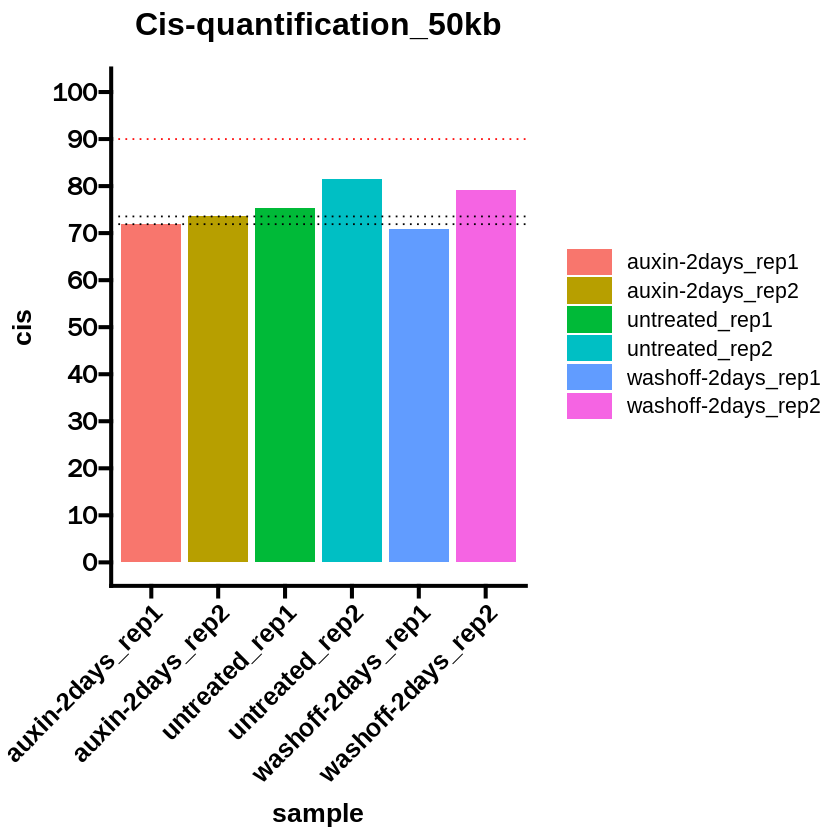

Saving 6.67 x 6.67 in image



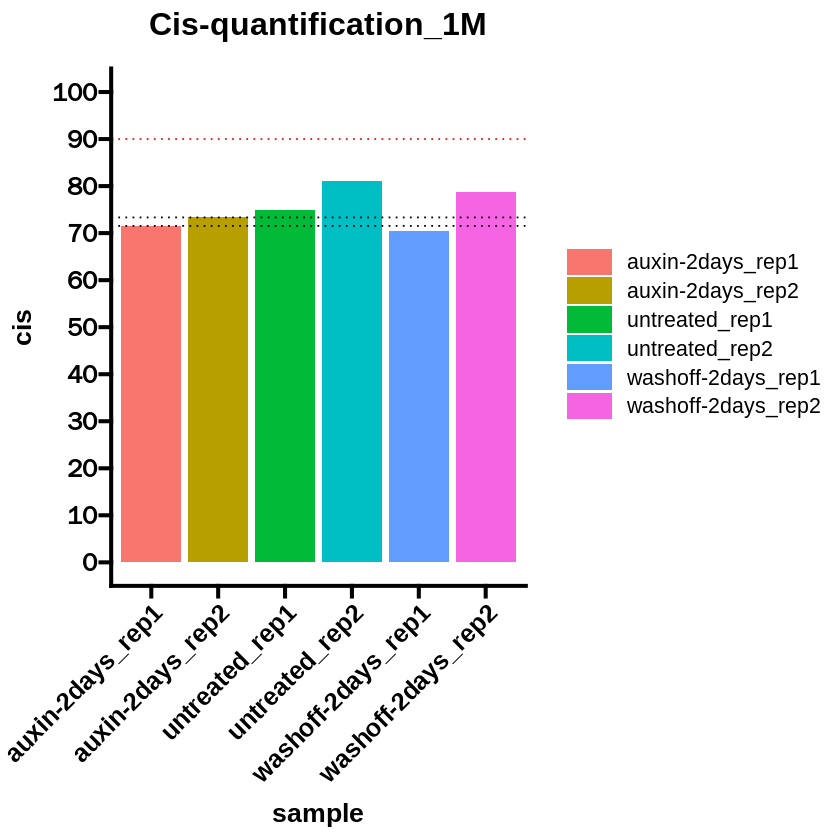

In [89]:
g1

ggsave('../genova_plots/Cis-quantification_50kb.pdf', g1)

g2
ggsave('../genova_plots/Cis-quantification_1M.pdf', g2)

## Chromosome plots
Hi-C has been shown to be a powerful data-source to detect chromosomal rearrangements [@Harewood2017]. To find possible translocations, we can plot the genome-wide enrichment of interactions between all combinations of chromosomes. The values in the matrix are $log_2(observed/expected)$. The Hap1 cell line has two known translocations, which we can easily see in the resulting plot (figure \@ref(fig:chromMat1)). To narrow-in on this location, you could use the `trans.compartment.plot`-function (discussed below).
```{r chromMat1, echo = F, message=FALSE, cache=F, fig.cap="Chromosome matrix. The two known translocations of Hap1 cells are easily identified (15-19 \\& 9-22).", fig.small = T}
# An automatic attempt is made to exclude the Y-chromosome and 
# mitochondrial genome
# Inversely, you can change the `include_chr` argument to select specific
# chromosomes
chr_mat <- chromosome_matrix(Hap1_WAPL_1MB)
visualise(chr_mat)
```

In [90]:
chr_mat <- chromosome_matrix(mESC_auxin_2days_rep1_1M)
g1 = visualise(chr_mat)
chr_mat <- chromosome_matrix(mESC_auxin_2days_rep2_1M)
g2 = visualise(chr_mat)
chr_mat <- chromosome_matrix(mESC_untreated_rep1_1M)
g3 = visualise(chr_mat)
chr_mat <- chromosome_matrix(mESC_untreated_rep2_1M)
g4 = visualise(chr_mat)
chr_mat <- chromosome_matrix(mESC_washoff_2days_rep1_1M)
g5 = visualise(chr_mat)
chr_mat <- chromosome_matrix(mESC_washoff_2days_rep2_1M)
g6 = visualise(chr_mat)

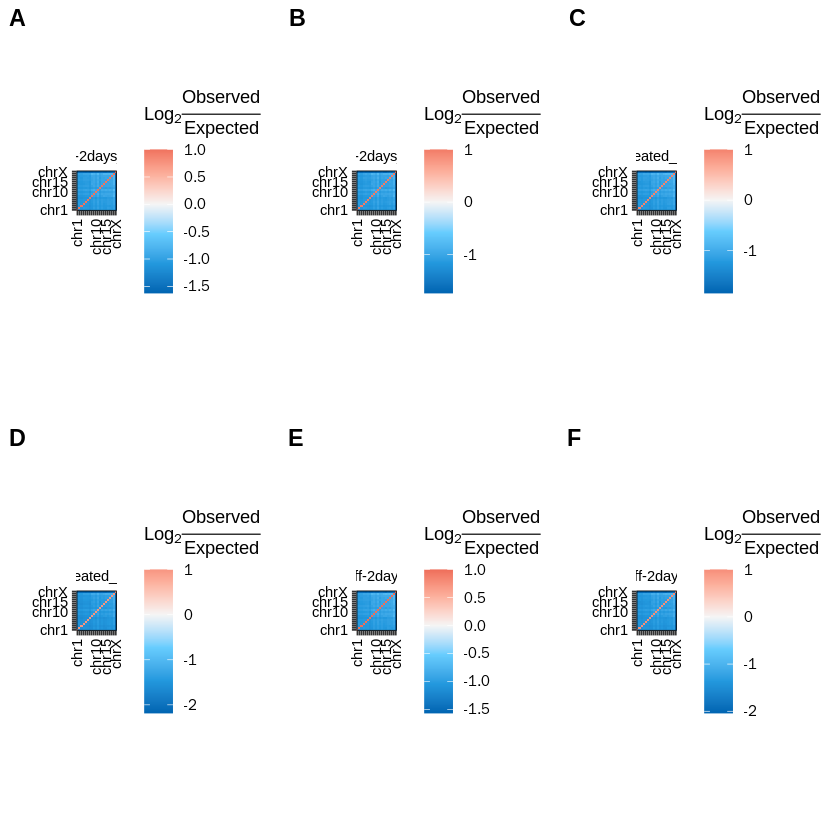

In [91]:
g <- plot_grid(g1, g2, g3, g4, g5, g6, labels=c("A", "B", "C", "D", "E", "F"), ncol = 3)
g

save_plot('../genova_plots/Chromosome_plots.pdf', g,
          ncol = 3, # we're saving a grid plot of 2 columns
          nrow = 2, # and 2 rows
          # each individual subplot should have an aspect ratio of 1.3
          base_aspect_ratio = 1.3)

## RCP
The Relative Contact Probability (RCP) computes the contact probability as a function of genomic distance, as described in [@Lieberman-Aiden2009]. This can be computed for a specific set of chromosomes or genome-wide. To ignore centromeric contacts (which have a aberrant RCP), centromeric information is needed. This is taken from the experiment-object or found empirically by comparing trans-interactions.

```{r doRCP, cache=F}
RCP_out <- RCP(explist = list(Hap1_WT_40kb, Hap1_WAPL_40kb), 
               chromsToUse = 'chr1')
```

The user can decide to plot the RCP per chromosome. If the data is sparse, a LOESS-smooting could be convenient. It takes the color and name from the experiment-objects. If we look at the resulting plot, we can see that the $\Delta WAPL$ has more interactions in the $[\pm\text{800kb}, \pm\text{2Mb}]$ range (figure \@ref(fig:RCPPLOT1)). The sizes of TADs are fall into this range, so a next step could be to dive into the TAD-specific analyses (discussed below). Moreover, the $\Delta WAPL$ has less interactions in the far-*cis* range ($[\pm\text{10Mb}, \pm\text{100Mb}]$): A- and B-compartments are often this size, so a next step could be to look more into compartmentalisation with `compartment_matrixplot` or `trans.compartment.plot`, for example.
```{r, echo=F}
options(scipen = 1)
```

```{r RCPPLOT1, cache=F, message=FALSE, fig.wide= T , fig.cap= "RCP. Every facet shows the RCP of one chromosome."}
visualise(RCP_out)
```

Saving 6.67 x 6.67 in image



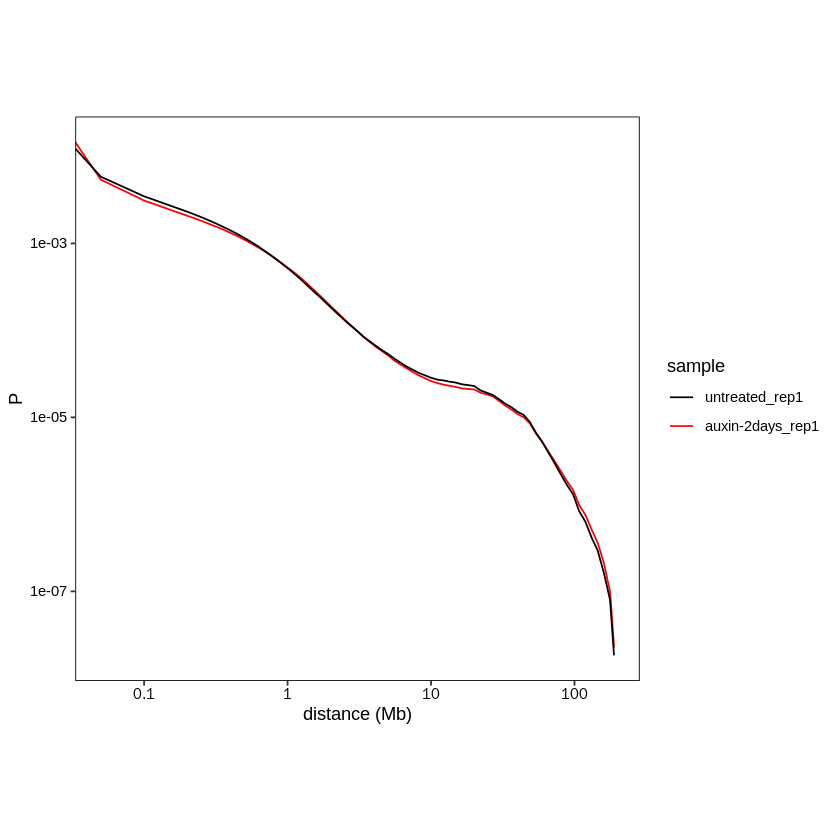

In [96]:
RCP_out <- RCP(explist = list(mESC_auxin_2days_rep1_50kb, mESC_untreated_rep1_50kb), 
               chromsToUse = 'chr1')

options(scipen = 1)
g <- visualise(RCP_out)
g
ggsave('../genova_plots/Relative_Contact_Probability_RCP_chr1.pdf', g)

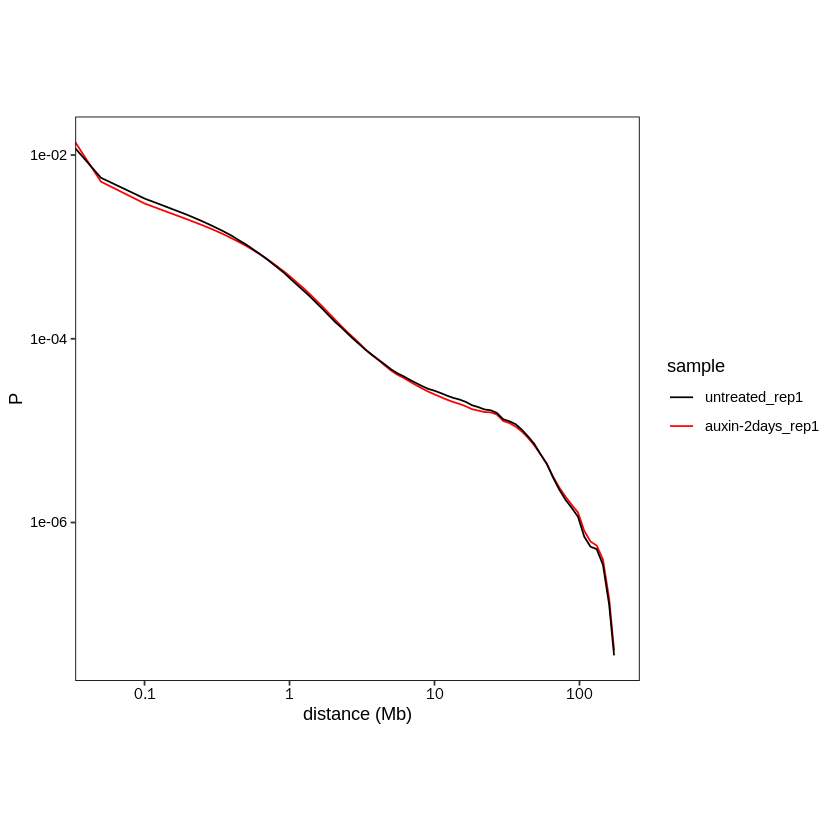

Saving 6.67 x 6.67 in image



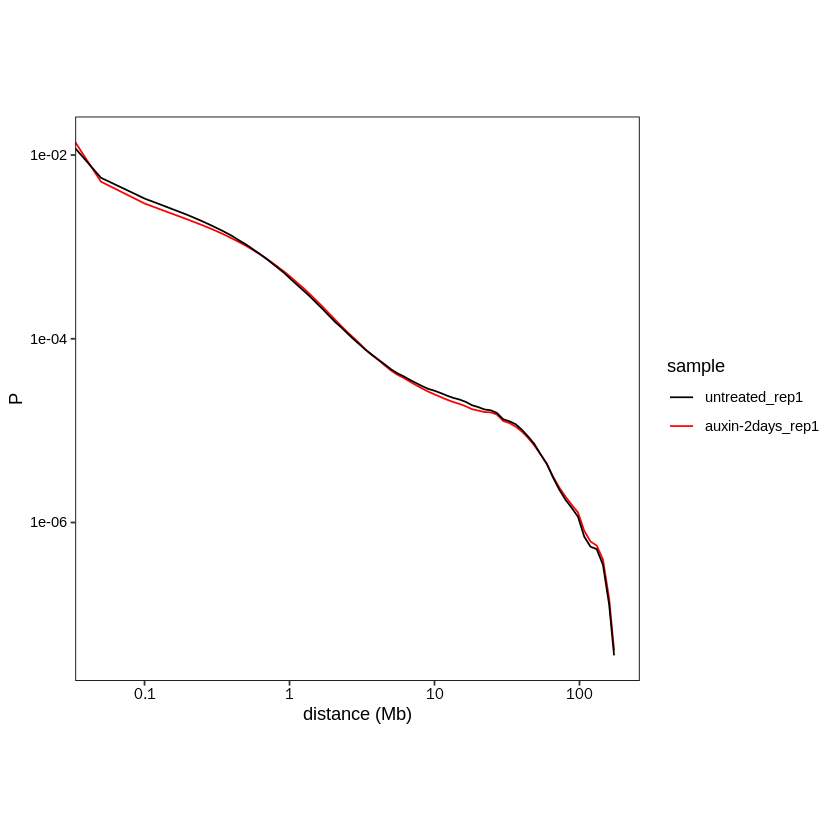

In [98]:
RCP_out <- RCP(explist = list(mESC_auxin_2days_rep1_50kb, mESC_untreated_rep1_50kb), 
               chromsToUse = 'chr2')

options(scipen = 1)
visualise(RCP_out)
g <- visualise(RCP_out)
g
ggsave('../genova_plots/Relative_Contact_Probability_RCP_chr2.pdf', g)

### Differentials
We can directly compare samples to one another (for example WT versus WAPL). To plot this, the `metric` argument has to be set to `lfc` and `contrast` to 1, indicating the WT sample (figure \@ref(fig:RCPPLOT2)). This plots the log-fold change of average probabilities.
```{r RCPPLOT2, message=FALSE,  cache=F, fig.small= T , fig.cap= "RCP in lfc-mode.", warning=FALSE}
# Plot RCP: combined
visualise(RCP_out, contrast = 1, metric = 'lfc')
```

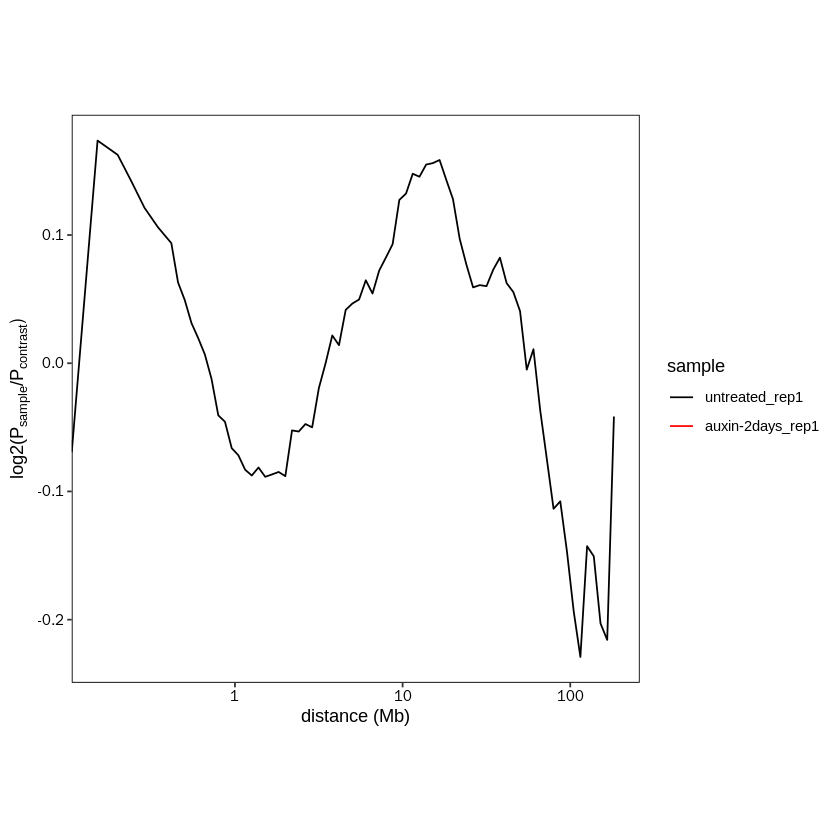

In [99]:
visualise(RCP_out, contrast = 1, metric = 'lfc')

### Regions
But what if you want to compare the contact probabilities of specific regions, like Cohesin- or CTCF-bound regions? For this purpose, we added the possibility to add a `list` of BED-`data.frame`s to the `bedList`-argument. Under the hood, we perform a standard per-arm RCP (thus still enabling users to set the `chromsToUse`-parameter). Thereafter, we filter out Hi-C bins that do not have entries in the `data.frame`(s) of `bedList`. The same plot-function `visualise()` can be used.
```{r RCPBED, message=FALSE,  cache=F, fig.small= F , fig.cap= "RCP with BEDs. We can also add BEDs as sites to compute the RCP."}
CTCF = read.delim('../data/symlinks/CTCF_WT_motifs.bed', header = FALSE)
SMC1 = read.delim('../data/symlinks/SMC1_WT_peaks.narrowPeak', header = FALSE)
RCP_out = RCP(list(Hap1_WT_40kb, Hap1_WAPL_40kb),
              bedlist =  list("CTCF" = CTCF, 
                              'Cohesin' =SMC1), 
              chromsToUse = 'chr1')
visualise(RCP_out)
visualise(RCP_out, contrast = 1, metric = 'lfc')
```

## A- and B-compartments
Dividing chromosomes into A- and B-compartments requires the calculation of a compartment score along with information about what parts of the genome are active. To infer which compartment is A (viewed as the active state) and which is B, we can add a BED-`data.frame` of ChIP-seq peaks from active histone marks (e.g. H3K27ac, H3K4me1). Below, we can use the `compartment_score()` function with H3K27ac peaks to distinguish the compartments. The compartment score uses the first eigenvector of an eigendecomposition on the distance-dependant observed/expected matrix to get an unsigned compartment score.  This score is then correlated to H3K27ac presence to yield signed compartment scores that can be interpreted as A compartments when positive and B compartments when negative.
```{r saddle, message=FALSE, cache=F, warning=FALSE, fig.cap= "The compartment-scores on chromosome 17.", fig.width=8}
H3K27acPeaks = read.delim('../data/symlinks/H3K27ac_WT.narrowPeak', 
                          header = FALSE)
CS_out = compartment_score(list(Hap1_WT_40kb, Hap1_WAPL_40kb), 
                           bed = H3K27acPeaks)
visualise(CS_out, chr = "chr17")
```

Warning message:
“Removed 122 row(s) containing missing values (geom_path).”


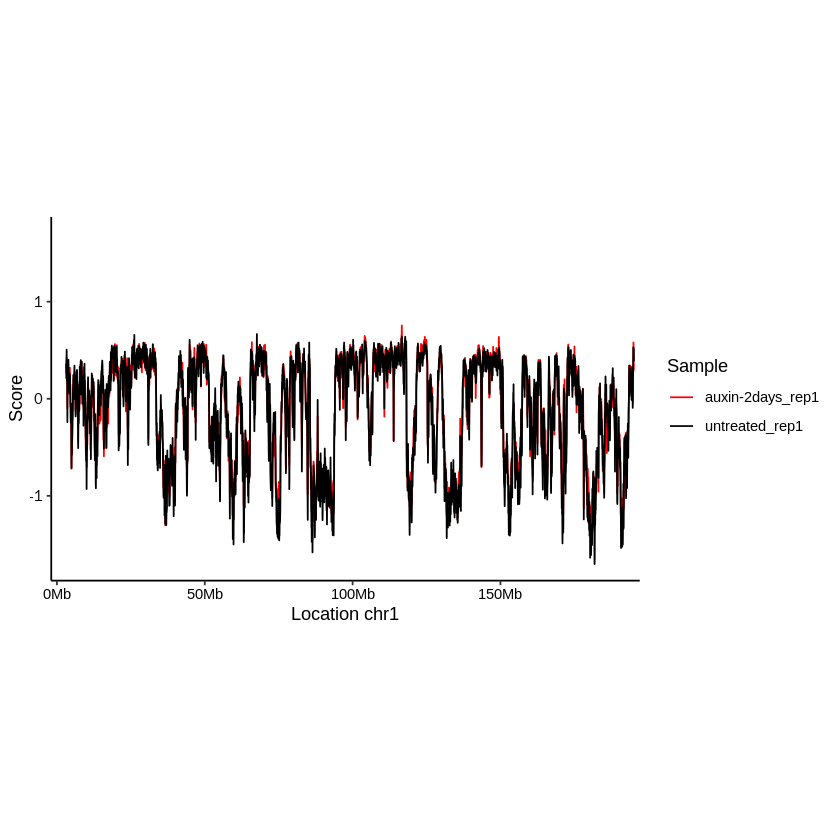

In [100]:
CS_out = compartment_score(list(mESC_auxin_2days_rep1_50kb, mESC_untreated_rep1_50kb), 
                           # bed = H3K27acPeaks
                          )
visualise(CS_out, chr = "chr1")

### Saddle-analyses
To illustrate the self-preference of compartments, one can use the `saddle()` function to perform a compartment score 'quantile versus quantile' analysis. Every chromosome arm is divided into quantiles based on the compartment score, and distance dependent observed over expected is computed. Every combination of quantile bins is then averaged to produce the saddle analysis.
```{r saddlePlot, message=FALSE,  fig.asp=.65, cache=F, warning=FALSE, fig.cap= "A saddle-plot: WAPL-knockout cells have less intra-compartment enrichment.", fig.width=8}
saddle_out = saddle(list(Hap1_WT_40kb, Hap1_WAPL_40kb), 
                   CS_discovery = CS_out,
                   bins = 50)
visualise(saddle_out)
```

Warning message:
“The 'CS_discovery' object is unsigned. It is strongly recommended that comparment scores are signed with `sign_comparmentscore()`.”


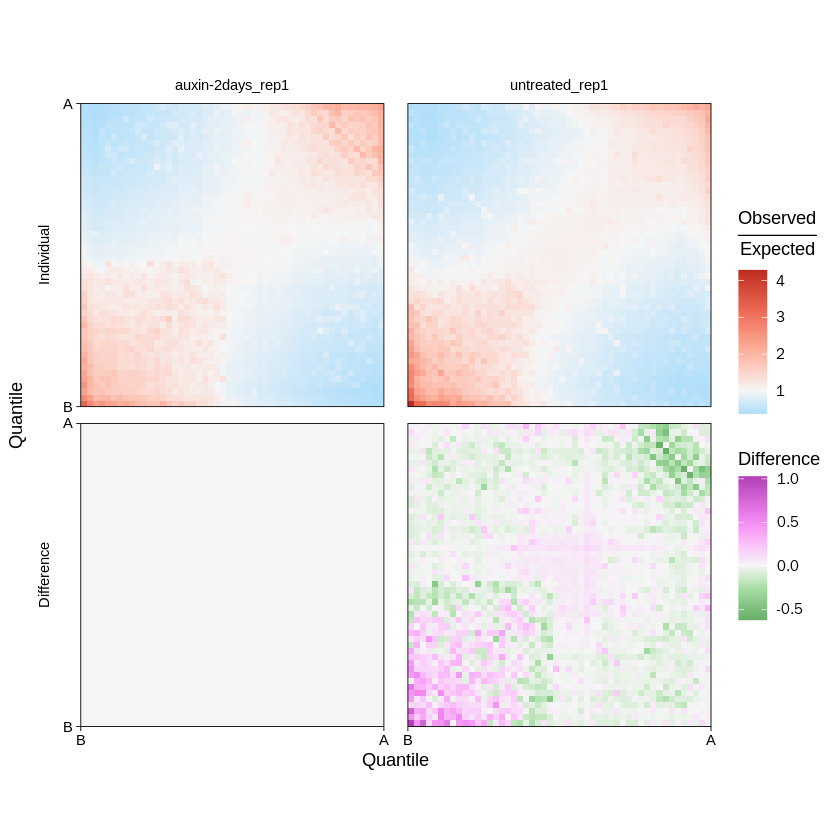

In [101]:
saddle_out = saddle(list(mESC_auxin_2days_rep1_50kb, mESC_untreated_rep1_50kb), 
                   CS_discovery = CS_out,
                   bins = 50)
visualise(saddle_out)

### Compartment-strength
The output of the saddle analysis gives a starting point for calculating the compartment strength, which gives a score for how much A-A and B-B interactions occur versus A-B interactions. The comparment strength can be calculated using the `quantify()` function on the output of the `saddle()` function.
```{r saddleStrength, message=FALSE,  cache=F, warning=FALSE, fig.cap= "The per-arm compartment strength is at almost every arm lower in the WAPL knockout.", fig.small = T}
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(WT, WAPL, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)
```

In [102]:
CSS <- quantify(saddle_out)
compared <- tidyr::spread(unique(CSS[,-c(3,4)]), key = 'exp', value = 'strength')
with(compared, plot(WT, WAPL, xlim = c(0,4), ylim = c(0,4), pch = 20))
abline(a = 0, b = 1, lty = 1)

ERROR: Error in plot(WT, WAPL, xlim = c(0, 4), ylim = c(0, 4), pch = 20): 找不到对象'WT'


# Interaction plots
GENOVA has several plotting-functions for genomic loci. `compartment_matrixplot()` and *trans.compartment.plot* provide a easy way to plot whole chromosome arms, including compartmentalisation-score tracks. For more zoomed-in plots, `hic_matrixplot()` can be used. This function also allows rich annotation and between-experiment comparison possibilities. All functions try to guess the most appropriate colour-scale limits, but finer control of this can be gotten by setting the `colour_lim`-argument.


## *Cis*-interactions 
The compartmentalisation of the chromatin into A and B van already described in the original Hi-C paper [@Lieberman-Aiden2009]. Serval papers have described the loss of compartmentalisation when the Cohesin complex is stabalised [@Haarhuis2017,@Wutz2017,@Gassler2017]. To view this interesting level of chromatin organisation, we can use `compartment_matrixplot()`. This function can plot one arm of a chromosome with the compartment-score plotted above.  In figure \@ref(fig:CCP1) you can see the resulting plots, where you can see that the chequerboard-pattern in the matrix and the amplitude of the compartment-score are diminished in the WAPL-knockout.
```{r CCP1, out.width='.49\\linewidth', fig.show='hold',fig.align='center', message=FALSE , fig.asp=1,fig.cap= "Cis compartment plot: WT vs WAPL. Stabilised Cohesin-mediated loops by WAPL-knockout leads to loss of compartments.",dev = 'png', dpi=300,cache=F}
compartment_matrixplot(
  exp1 = Hap1_WT_40kb,
  exp2 = Hap1_WAPL_40kb,
  CS_discovery = CS_out,
  chrom = "chr14", arm = "q",
  colour_lim = c(0, 15)
)
```

The compartment-score is calculated by performing an eigenvector decomposition on the correlation-matrix of the expected over expected matrix. To view this observed over expected matrix, we can set the `metric`-option to `"obsexp"`. Alternatively, we can set `metric = "correlation"` to view the Pearson correlation of the observed over expected matrix. These metrics gives a visually better indication of the A- and B-compartments (figure \@ref(fig:CCP3)). 
```{r CCP3, message=FALSE , fig.asp=1,fig.cap= "Cis compartment plot. Observed over expected.",dev = 'png', dpi=300,cache=F, fig.retina=T, fig.small = T}
compartment_matrixplot(
  exp1 = Hap1_WT_40kb,
  exp2 = Hap1_WAPL_40kb,
  CS_discovery = CS_out,
  chrom = "chr20", arm = "q",
  metric = "log2obsexp"
)
```

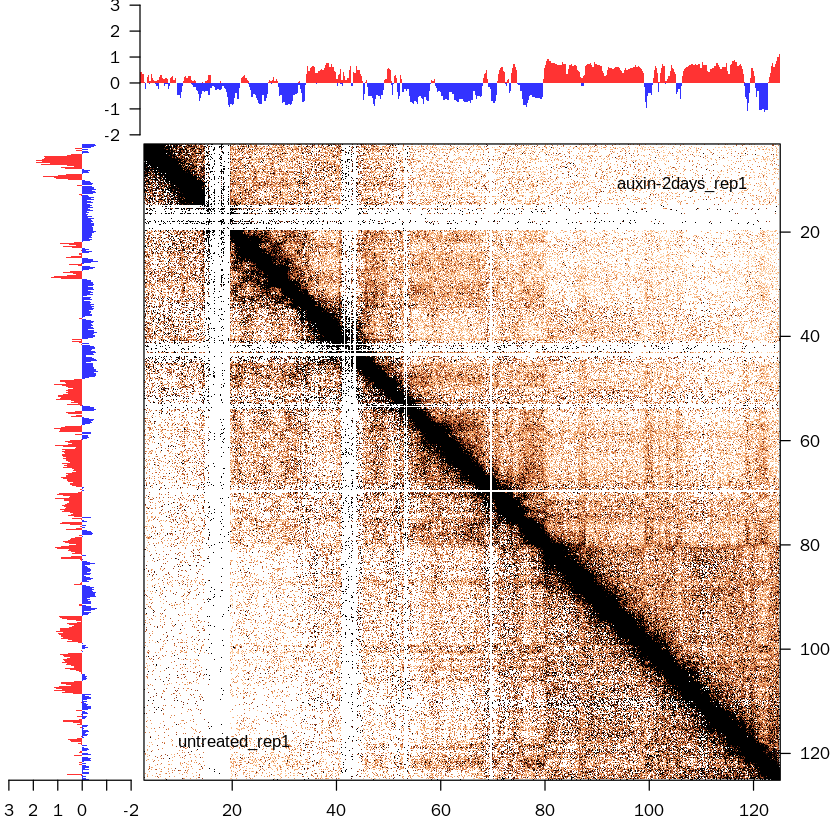

In [103]:
compartment_matrixplot(
  exp1 = mESC_auxin_2days_rep1_50kb,
  exp2 = mESC_untreated_rep1_50kb,
  CS_discovery = CS_out,
  chrom = "chr14", arm = "q",
  colour_lim = c(0, 15)
)

## *Trans*-interactions 
The function `trans_matrixplot()` will allow the user to plot a trans-matrix (i.e. a matrix of the arms of two different chromosomes). This function could also be used to investigate chromosomal translocations: the $\text{9q;22q}$ translocation can be clearly seen if we use this function, as in figure \@ref(fig:TCP).
```{r TCP, message=FALSE , fig.asp=1,fig.cap= "Trans compartment plot. The t(9q;22q) translocation is easily identified.",dev = 'png', dpi=300,cache=F, fig.retina=T, fig.small = T}
trans_matrixplot(
  Hap1_WT_40kb,
  chrom_up = "chr9", start_up = 100e6, end_up = 140e6,
  chrom_down = "chr22", start_down = 16e6, end_down = 40e6,
  colour_lim = c(0, 20)
)
```

## Matrix plots
To produce richly annotated zoomed-in (i.e. max 10Mb) plots of specific regions, we use the `hic_matrixplot()` function. In this, we can use one or two experiment objects: two can be shown either in diff-mode (the difference between the two) or upper/lower triangle mode. TAD- and loop-annotations can be added, as well as bigwig- and bed-tracks. Moreover, genemodel-files can be added. In this section, we will build up to a final, fully annotated, matrix from a humble one-experiment plot (figure \@ref(fig:HMP1)).
```{r HMP1, message=FALSE , fig.asp=1,fig.cap= "Hi-C matrixplot. Simplest example: one experiment, no annotation",dev = 'png', dpi=300,cache=F, fig.retina=T, fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               cut.off = 50) # upper limit of contacts
```

### Two experiments
Adding a second experiment will give us the option of `coplot`, which can be `dual` (default) or `diff`. The left plot shows the WT sample in the upper triangle and KO sample in the lower. In the right plot, the KO sample is subtracted from the WT in `diff`-mode: red is therefore more contacts in the KO and blue denotes more contacts in the WT (figure \@ref(fig:HMPdiff1)).
```{r HMPdiff1, out.width='.49\\linewidth', fig.show='hold',fig.align='center',  message=FALSE , fig.asp=1,fig.cap= "Hi-C matrixplot with two experiments: dual vs diff mode. The extended loops in the WAPL knockout are easily seen at around 28Mb in the lower triangle in dual-mode (left panel) and as red points in diff-mode (right panel).",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.wide = T}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               exp2 = Hap1_WAPL_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               cut.off = 50) # upper limit of contacts
hic_matrixplot(exp1 = Hap1_WT_10kb,
               exp2 = Hap1_WAPL_10kb,
               coplot = 'diff',
               chrom = 'chr7',
               start = 25e6,
               end=30e6, # upper limit of contacts
               cut.off = 25) 
```

### TADs and loops
It can be very useful to annotate the matrix with the positions of TADs and loops: take, for example, the situation where these structures are altered in a knockout for example. We are going to use the TAD- and loop-calls of WT Hap1 20-kb matrices from Haarhuis et al. [-@Haarhuis2017], generated with HiCseg [@Levy-Leduc2014].

Lets load some TAD- and loop-annotations:
```{r loadLOOP_mp, cache=F}
WT_TADs  = read.delim('../data/symlinks/WT_hicseg_TADs.bed', h = F)
WT_Loops = read.delim('../data/symlinks/WT_HICCUPS.bedpe', h = F, skip = 1)
sanborn2015_Loops = read.delim('../data/symlinks/GSE74072_Hap1_HiCCUPS_looplist.txt.gz')
```

```{r fixLOOP_mp, echo = F, cache=F}
WT_Loops$V1 = gsub(pattern = "^", replacement = "chr", x = WT_Loops$V1) 
WT_Loops$V4 = gsub(pattern = "^", replacement = "chr", x = WT_Loops$V4)
WT_TADs = WT_TADs[!WT_TADs$V3 < WT_TADs$V2,] 
sanborn2015_Loops[,1] = gsub(sanborn2015_Loops[,1], pattern = "^", replacement = "chr")
sanborn2015_Loops[,4] = gsub(sanborn2015_Loops[,4], pattern = "^", replacement = "chr")
```

Add them to the plot by using the `tad`- and `loops`-arguments. Both can be plotted in one or both of the triangles and coloured as deemed appropriate (figure \@ref(fig:HMPtadloop)). Since loops are very small in a hic-matrixplot, they will be fully overlapped by the loop-annotations. To overcome this, we expand the annotations with a fixed distance in basepairs using `loops.resize`. This will draw a circle around the loop location. 
```{r HMPtadloop, out.width='.49\\linewidth', fig.show='hold',fig.align='center', fig.wide = T, message=FALSE , fig.cap= "Hi-C matrixplot: TAD- and loop-annotations from Haarhuis et al. (2017).",cache=F,fig.asp=1, dev = 'png', dpi=300}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=30e6, 
               loops = WT_Loops, # see APA
               loops.colour = 'blue', # blue loops
               loops.type = 'upper', # only plot in upper triangle
               loops.radius = 20e3, # expand for visibility
               tads = WT_TADs, # see ATA
               tads.type = 'lower', # only plot in lower triangle
               tads.colour = 'limegreen', # green TAD-borders
               cut.off = 25) # upper limit of contacts
```

### BigWigs and BEDs
Manipulation of CTCF-binding sites can result in loss or gain of loops and/or TADs [@DeWit2015a]. If you are interested in the effects of a knockout on the binding of a protein in combination with changes in interaction frequencies, adding ChIP-seq signal or -peaks to the matrix can be helpful. You can add up to two tracks above and two tracks to the left. These can be either BED-like `data.frame`s or the paths to the `.bw` files. For example, let's load a BED6-file (chrom, start, end, name, score, and strand ^[https://genome.ucsc.edu/FAQ/FAQformat.html]) of CTCF-motifs under CTCF-ChIP peaks. The argument `type` can be set to either *triangle* or *rectangle*. The triangle is nice to use if you want to look at the orientation of the BED-entries (figure \@ref(fig:HMPchip)). If you only have a three column BED, then the output will always be *rectangle*.
```{r CTCF, cache=F}
CTCF = read.delim('../data/symlinks/CTCF_WT_motifs.bed', h = F)
SMC1 = read.delim('../data/symlinks/SMC1_WT_peaks.narrowPeak', h = F)
```

```{r, echo =F }
knitr::kable(
  head(CTCF, 3), caption = 'A data.frame holding a standard BED6 format.'
)
```

Moreover, we can use a bigwig (.bw) file to plot a track. For this example, we are using a SMC1 ChIP-seq track from [@Haarhuis2017]. We load the bigwig data with the `rtracklayer` package that is available from Bioconductor. The `yMax` argument is handy if you want to compare bigwig-tracks: it lets you set the y-axis maximum.

```{r HMPchip, message=T , fig.cap= "Hi-C matrixplot: ChIPseq. A BED-file of CTCF-sites is plotted at the top and a coverage-track of SMC1 ChIP-seq is plotted beneath this. The symmAnn-option leads to the same tracks being plotted on the left.",cache=F,fig.asp=1, dev = 'png', dpi=300,fig.small = F}
requireNamespace("rtracklayer", quietly = TRUE)
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',  start = 26.75e6,  end=28.5e6, 
               loops = WT_Loops, # see APA
               loops.colour = 'purple', # purple loops
               loops.type = 'upper', # only plot in upper triangle
               loops.radius = 20e3, # expand for visibility
               type = 'triangle',
               chip = list('../data/symlinks/SMC1_WT.bw', # inner top
                           CTCF),# outer-top
               symmAnn = F, # place annotations also on left side
               cut.off = 65) # upper limit of contacts
```

### Genes
[@Dixon2012] showed that housekeeping-genes are enriched in the vicinity of TAD-borders. Another interesting question could be whether differentially expressed genes are also found near TAD-borders or binding sites of specific proteins when studying a knockout. These type of questions can be tackled by adding the appropriate gene-models to `hic_matrixplot()`. To do this, we use a `data.fame`, where each row is an exon of a gene. There are several ways to get this, and one of the easier ways is to use biomart to get exon-coordinates. You could use the biomaRt-package or the web-based service. For this example, we downloaded data of all exons from the Ensembl biomart and plotted both the BED-file and the genes (figure \@ref(fig:HMPchipGene)).
```{r biomart}
# features downloaded:
## Gene stable ID & Transcript stable ID & Chromosome/scaffold name &
## Transcript start (bp) & Transcript end (bp) & Exon region start (bp) &
## Exon region end (bp) & Strand
# martExport = read.delim('../data/mart_export.txt.gz', stringsAsFactors = F)
# colnames(martExport) = c('ENSG','ENST','chrom' , # change column names
#                          'txStart' , 'txEnd' , 
#                          'exonStart' , 'exonEnd' , 'strand')
# martExport$chrom = gsub(martExport$chrom, # add chr-prefix
#                         pattern = '^',
#                         replacement = 'chr') 
# martExport$strand = ifelse(martExport$strand == 1, '+',"-") # 1/-1 to +/-
load('../data/symlinks/../martExport.Rdata')
```

```{r, echo =F }
knitr::kable(
  head(martExport[,-c(1,2)], 5), caption = 'A data.frame holding the needed columns for plotting genes.'
)
```


```{r HMPchipGene, message=FALSE , cache=F, fig.cap= "Hi-C matrixplot: genes.",fig.asp=1, dev = 'png', dpi=300,fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',  start = 26.75e6,  end=28.5e6, 
               genes = martExport,
               cut.off = 65) # upper limit of contacts
```

### Everthing together
Finally, we can combine all these options in one. This might put too much information in a single plot, but it can be quite handy. In this example, we can see that most TAD-borders and loop-anchors have clear SMC1- and CTCF-signal (figure \@ref(fig:HMPall)). Both these are expected to be found at these locations according to the *chromatin extrusion model*. Moreover, we can also see that the CTCF-orientation of the upstream and downstream loop-anchor are forward and reverse, respectively. This *convergent rule* is a known feature of loops [@DeWit2015]. 

```{r HMPall, message=FALSE , fig.cap= "Hi-C matrixplot: a complex case. Loops and TADs are annotated within the Hi-C matrix. On the top annotation-bar, we have plotted the ChIP-seq signal and peaks of SMC1. On the left annotation-bar are the ChIP-seq signal and peaks (with orientiation) of CTCF. Genes are plotted on both annotation-bars.",cache=F,fig.asp=1, dev = 'png', dpi=300,fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=28.5e6, 
               loops = WT_Loops, # see APA
               loops.colour = '#998ec3', # purple loops
               loops.type = 'upper', # only plot in upper triangle
               loops.radius = 20e3, # expand for visibility
               genes = martExport,
               chip.colour = 'black',
               chip = list('../data/symlinks/SMC1_WT.bw', # inner-top
                           SMC1, # outer-top
                           '../data/symlinks/SMC1_WT.bw', # inner-left
                           CTCF), # outer-left
               tads = WT_TADs, # see ATA
               tads.type = 'lower', # only plot in lower triangle
               tads.colour = '#91cf60', # green TAD-borders
               cut.off = 50) # upper limit of contacts
```    

## Pyramid plots

In GENOVA, 'pyramid plots' are plots of a region in the Hi-C interaction map rotated at an 45 degree angle (figure \@ref(fig:pyramidBasic)). This rotation coincides the diagonal with the x-axis, and the y-direction indicates distance from the diagonal.

```{r, pyramidBasic, fig.cap= "A pyramid plot, showing a rotated Hi-C interaction map.",cache=F, dev = 'png', dpi=300}
pyramid(exp = Hap1_WT_10kb,
        chrom = 'chr7',
        start = 25e6,
        end=28.5e6,
        colour = c(0, 50))
```

Pyramid plots can be cropped in the x-and y-direction to make them more space efficient (figure \@ref(fig:pyramidRect)).

```{r, pyramidRect, fig.cap= "A cropped pyramid no longer looks like a pyramid.",cache=F, dev = 'png', dpi=300}
pyramid(exp = Hap1_WT_10kb,
        chrom = 'chr7',
        start = 25e6,
        end=28.5e6,
        crop_x = c(26e6, 27.5e6), # cropping in x direction uses locations
        crop_y = c(0, 2e6), # cropping in y direction uses distance
        colour = c(0, 50))
```

For comparing two different samples with pyramid plots, there are two options. The first option is to use `pyramid_difference()`, which works very similar to `pyramid()`, but takes two samples instead of one \@ref(fig:pyramidDiff)). 

```{r, pyramidDiff, fig.cap= "A pyramid plot showing the difference between two samples.",cache=F, dev = 'png', dpi=300}
pyramid_difference(
  Hap1_WT_10kb,
  Hap1_WAPL_10kb,
  chrom = "chr7", start = 25e6, end = 28.5e6
)
```

The alternative option is to stack the plots together using plot composition. Because `pyramid()` is based on the ggplot2 package, we can use the patchwork plot composition package to stack two (or more) plots \@ref(fig:pyramidPatch)).

```{r, pyramidPatch, fig.cap= "Using the patchwork package to stack pyramid plots.",cache=F, dev = 'png', dpi=300}
library(patchwork)
wt_pyramid <- pyramid(
  Hap1_WT_10kb,
  chr = "chr7", start = 25e6, end = 28.5e6,
  crop_y = c(0, 1.5e6),
  colour = c(0, 50)
) + ggplot2::ggtitle("Wildtype")
ko_pyramid <- pyramid(
  Hap1_WAPL_10kb,
  chr = "chr7", start = 25e6, end = 28.5e6,
  crop_y = c(0, 1.5e6),
  colour = c(0, 50)
) + ggplot2::ggtitle("WAPL KO")
ko_pyramid / wt_pyramid + plot_layout(guides = "collect")
```

# TADs
Topologically Associated Domains (TADs) are $\pm0.8-2\text{Mb}$ regions, which are seen as triangles in the matrix: regions that have more interactions within than outside. GENOVA has a repertoire of functions to generate and analyse TADs. Fist, we will use the insulation score to call TADs and compare the strength of TAD-borders between samples. Next, we will explore `ATA()` to analyse aggregates of TADs. Finally, we'll investigate whether TADs interact with their neighbouring TADs.

## Insulation
To estimate the strength of TAD-borders, we can look at the insulation-score [@Crane2015]. At a TAD-border, this score reaches a local minimum: the lower the score, the stronger the insulation. We can generate this for a specific sliding-window size with `insulation_score()`. The choice of window-size is quite tricky, since smaller windows will be sensitive to very local effects (i.e. mapping-errors, loops), while too big windows will lead a an under-representation. Luckily, we can generate a domainogram of a range of window-sizes for a specific genomic region with `insulation_domainogram`.

### Domainogram
To make a domainogram, we simply choose our experiment and our region of interest. The window-size is directly proportional to the amount of Hi-C bins.

```{r domainogram, message=FALSE , dev = 'png', dpi=300, fig.asp=.3, cache=F, fig.retina=T,fig.small = F, fig.cap= "Insulation domainogram. Insulation-hotspots can be identified in red, which are regions with a very negative score."}
ID <- insulation_domainogram(
  Hap1_WT_10kb,
  chrom = 'chr7', 
  start = 25e6,
  end   = 29e6, 
  window_range = c(1, 101),
  step = 2
)
visualise(ID)
```

A nice feature of `hic_matrixplot()` is that if you use it without plotting anything on the sides (i.e. genes and/or ChIP-tracks), you can insert other plots. This allows us to plot the domainogram directly under the matrix, making it very easy to compare the insulation with the actual data (figure \@ref(fig:domainogram2)).
```{r domainogram2, message=FALSE , fig.asp=1,fig.cap= "Insulation domainogram with Hi-C matrix. The insulation-hotspots are the sites where HiC-seg has called a TAD-border.",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.small = F}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               chrom = 'chr7',
               start = 25e6,
               end=29e6, 
               tads = WT_TADs, # see ATA
               tads.type = 'upper', # only plot in lower triangle
               tads.colour = '#91cf60', # green TAD-borders
               cut.off = 25, # upper limit of contacts
               skipAnn = T) # skip the outside annotation
plot(ID, minimalist = TRUE)
```

### Computing the insulation score
To get the genome-wide insulation score in .bedgraph-format ^[BED3 + signal column], we provide the `insulation_score()` function, that takes a contacts-object and the window-size of choice. As can be seen in the domainogram above, at $W=25$ we will catch the majority of the hotspots, while limiting the amount of noise. The `visualise()`-function can show both the insulation-scores and the difference between them.
```{r generateINS, cache=F}
Hap1_10kb_insulation <- insulation_score(
  list(Hap1_WT_10kb, Hap1_SCC4_10kb),
  window = 25
)
visualise(Hap1_10kb_insulation, 
          chr = 'chr7', start = 25e6, end=29e6, 
          contrast = 1)
```

### Insulation-heatmap
We can align the border-strength of TADs in multiple samples to a specific BED-file, to compare *"borderness"* of feature. For example, let's use the TAD-borders from [@Haarhuis2017]. In figure \@ref(fig:INSalign) we can see that the average signal drops at the border (which is to be expected) and that this is a genome-wide feature, as we see in the heatmap.
```{r INSalign, message=FALSE , fig.asp=1,fig.cap= "Insulation heatmap. The upper panel shows the average score. Each row is a TAD-border in the lower panel.",cache=F, fig.retina=T, dev = 'png', dpi=300,fig.small = T}
tornado_insulation(Hap1_10kb_insulation, bed = CTCF, bed_pos = 'center')
```


## Call TADs
The `insulation`-discovery object can also be used to call TADs.
```{r callTAD, cache=F, cache.lazy=F}
TADcalls <- call_TAD_insulation(Hap1_10kb_insulation)
```

```{r plotTADCALLS, cache=F, echo = T, fig.asp=1, dev = 'png', dpi=300, fig.cap="TADs called within GENOVA."}
hic_matrixplot(exp1 = Hap1_WT_10kb,
               exp2 = Hap1_SCC4_10kb,
               chrom = 'chr7',
               start = 24e6,
               end=27e6, 
               tads = list(TADcalls$SCC4, TADcalls$WT), # see ATA
               tads.type = list('lower', 'upper'), # only plot in lower triangle
               tads.colour = c('green', 'grey'), # green TAD-borders
cut.off = 25) # upper limit of contacts
```

## ATA

TADs can be investigated globally by aggregating Hi-C matrix around TADs. In aggregate TAD analyses (ATA), because TADs have different sizes, they are rescaled to a uniform size and then the result is averaged across the genome.

```{r ATA, cache=F}
ATA_Hap1_WTcalls <- ATA(list("WT" = Hap1_WT_10kb,
                             'WAPL' = Hap1_WAPL_10kb),
                        bed = TADcalls$WT) 
```

We can use `visualise()` to plot the ATA-results.

```{r ATAplot, message=FALSE , dev = 'png', dpi=300,fig.cap= "ATA. In the WAPL-knockout, we see a decrease of contacts within the TAD, but an increase at the corner.",cache=F}
visualise(ATA_Hap1_WTcalls, 
          colour_lim = c(0,50),
          colour_lim_contrast = c(-5,5), 
          metric = "diff",
          focus = 1) # which entry to use as comparison
```

## TAD+N

A TAD+N analysis computes the interaction density within TADs and their 1,2,...,N neighbours. This can be used to compare whether TADs in two samples interact differently with their neighbouring TADs.

```{r ii, cache=F}
TAD_N_WT   <- intra_inter_TAD(list("WT" = Hap1_WT_10kb,
                                   'WAPL' = Hap1_WAPL_10kb),
                              tad_bed = TADcalls$WT, 
                              max_neighbour = 10)
```

We can compute the enrichment of contacts between TADs with the `visualise()`-function. 
```{r iiDIFF, message=FALSE , fig.cap= "Differential TAD-analysis. Experiment 2 (WAPL) has more interactions between neighbouring TADs compared to wild type.",dev = 'png', dpi=300, cache=F, fig.retina=T}
visualise(TAD_N_WT, geom = 'jitter')
visualise(TAD_N_WT, geom = 'violin')
```

# Loops
For this section, we are using both the called primary and the extended loops from Haarhuis et al. [-@Haarhuis2017]. The primary loops are the anchor-combinations of the merged loop-calls of WT Hap1 5-, 10- and 20-kb matrices, generated with HICCUPS [@Rao2014]. The extended loops are called by taking the primary loops and taking combinations of 5' and 3' anchor locations that are larger than the input loops, up to some distance.
```{r loadLOOP, cache=F}
# Anchors are defined as a matrix with two columns of bin IDs
WT_Loops_extended = anchors_extendedloops(Hap1_WT_10kb$IDX, 
                                          res = resolution(Hap1_WT_10kb), 
                                          bedpe = WT_Loops)
```

```{r, echo=F}
options(scipen = 1e9)
```

```{r fixLOOP, echo = F, cache=F, warning=FALSE}
knitr::kable(
  head(as.data.frame(WT_Loops_extended), 5), caption = "Anchor-combinations of anchors_extendedLoops"
)
```

```{r, echo=F}
options(scipen = 1)
```

## APA
Aggregate peak analysis (APA) looks up small portions of the Hi-C matrix from a twodimensional set of locations, such as loops. These are then aggregated to get a genome wide impression of the loops.
```{r APArun, cache=F}
APA_Hap1_WT  <- APA(list("WT" = Hap1_WT_10kb,
                          'WAPL' = Hap1_WAPL_10kb),
                    dist_thres = c(200e3, Inf),
                    bedpe = WT_Loops)
APA_Hap1_WT_extended <- APA(list("WT" = Hap1_WT_10kb,
                               'WAPL' = Hap1_WAPL_10kb),
                            bedpe = WT_Loops,
                            dist_thres = c(200e3, Inf),
                            anchors = WT_Loops_extended)
```

Once again, we can use `visualise()` to make plots of the APA results.
```{r APAplot, message=FALSE , fig.cap= "APA. In the WAPL-knockout, we see an increase of contacts at the loop.",cache=F, fig.retina=T}
visualise(APA_Hap1_WT,
          title = "Hap1 Hi-C WT vs WAPL-KO loops", 
          colour_lim = c(0, 40), # set the colour limits of the upper row
          colour_lim_contrast = c(-5, 5),
          metric = "diff",
          contrast = 1) # Compare against 1st sample in APA_Hap1_WT
visualise(APA_Hap1_WT_extended,
          title = "Hap1 Hi-C WT vs WAPL-KO extended loops", 
          colour_lim = c(0, 8), # set the colour limits of the upper row
          colour_lim_contrast = c(-4, 4),
          metric = "diff",
          contrast = 1) # Compare against 1st sample in APA_Hap1_WT_extended
```

To get some basic statistics on the output(s) of APA-run(s), we use `quantify()`. This function averages the region surrounding the center of each loop, where a region is defined as a square of $\text{pixel width} \times \text{pixel width}$.
```{r quantAPA, message=FALSE , fig.cap= "With quantifyAPA In the WAPL-knockout, we see an increase of contacts at the loop.",cache=F, fig.retina=T}
quantifyAPA_out <-  quantify(APA_Hap1_WT)
quantifyAPA_out_extended <-  quantify(APA_Hap1_WT_extended)
# plot boxplot with base-R (ggplot2 would be also easy)
boxplot(split(quantifyAPA_out_extended$per_loop$foldchange, 
              f = quantifyAPA_out_extended$per_loop$sample), 
        col = c('red', 'darkgrey'), outline = F, 
        ylab = 'pixel enrichment extended loops')
```


# Far-cis interactions
## PE-SCAn
Some regulatory features, like super-enhancers come together in 3D-space. To test this, we implemented PE-SCAn. Here, the enrichment of interaction-frequency of all pairwise combinations of given regions is computed. The background is generated by shifting all regions by a fixed distance (1Mb: can be changed with the `shift`-argument).
```{r SE1, cache=F}
superEnhancers = read.delim('../data/symlinks/superEnhancers.txt',
                            header = FALSE, 
                            comment.char = "#")
```

```{r, echo =F , cache=F}
knitr::kable(
  head(superEnhancers[,1:6], 5), caption = "A data.frame holding the output of homer's findPeaks -style super."
)
```

The standard visualisation is comparable to ATA and APA: the first row shows the enrichment of all included samples, while the bottom row shows the difference.
```{r PESCAn, message=FALSE , fig.cap= "PE-SCAn. There is a pairwise enrichment of contacts between Superenhancers, compared to shifted regions in the WT.",cache=F, fig.retina=T, fig.small = T}
WT_PE_OUT = PESCAn(list(Hap1_WT_40kb, Hap1_WAPL_40kb), bed = superEnhancers[,2:4])
visualise(WT_PE_OUT)
```

Another way of looking at the PE-SCAn results, is to make a perspective plot. Here, the enrichment is encoded as the z-axis.
```{r pePERS, message=FALSE , fig.cap= "PE-SCAn perspective plot.",cache=F, fig.retina=T}
persp(WT_PE_OUT, border = NA,
      cex.axis = 0.6, cex.lab = 0.6)
```


## centromere.telomere.analysis

We saw a enriched signal between chromosomes 15 and 19. We can wh
```{r cent1, cache=F, eval=F}
out1519 = centromere.telomere.analysis(Hap1_WT_40kb, chrom.vec = c('chr15', 'chr19'))
draw.centromere.telomere(out1519)
```
```{r cent2, cache=F, echo = F, fig.cap='Centromere-telomere plot of chromosomes 15 and 19.'}
par(pty ='s')
out1519 = centromere.telomere.analysis(Hap1_WT_40kb, chrom.vec = c('chr15', 'chr19'))
draw.centromere.telomere(out1519)
```




Please post questions, comments and rants on [our github issue tracker](https://github.com/robinweide/GENOVA/issues).

# Session info

```{r sesh, echo = F}
sessionInfo()
````

# References
